In [16]:
# project imports
import env
from wayback_search import POLICY_DIR
from build_master_index import MASTER_CSV, PROBLEM_COMPANIES


# python & package imports
import pandas as pd
import os


# plot things
%matplotlib inline
# autoreload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv(MASTER_CSV)
df.policy_date = pd.to_datetime(df.policy_date)
#df['policy_year'] = df.policy_date.dt.year
#df['policy_month'] = df.policy_date.dt.year
#df['policy_day'] = df.policy_date.dt.year
df.head()

,company,policy_date,policy_url,policy_path
0,1password,2017-02-02,https://1password.com/legal/privacy/privacy-20...,1password/1password-2017-02-02.txt
1,1password,2017-03-16,https://1password.com/legal/privacy/privacy-20...,1password/1password-2017-03-16.txt
2,1password,2017-08-02,https://1password.com/legal/privacy/privacy-20...,1password/1password-2017-08-02.txt
3,1password,2018-03-15,https://1password.com/legal/privacy/privacy-20...,1password/1password-2018-03-15.txt
4,1password,2018-04-04,https://1password.com/legal/privacy/privacy-20...,1password/1password-2018-04-04.txt


In [3]:
print(len(df.company.unique()))
print(len(df.policy_path.unique()))
print(len(df))

18
227
239


In [4]:
# sometimes duplicate csv rows appear because of overlap in the
# dates of two configurations; they are the same policy most likely
# so we just drop the duplicate
df = df[~df.duplicated('policy_path')]
len(df)

227

In [5]:
# some companies proved more difficult than others when gathering
# privacy policies, so we drop them here (the policies are left
# as part of the original dataset because they are valid policies,
# but we do not have all the revisions)
df = df[~df.company.str.contains('|'.join(PROBLEM_COMPANIES))]
len(df)

199

In [6]:
df.company.unique()

array(['1password', 'amazon', 'apple', 'cisco', 'facebook', 'fitbit',
       'goodreads', 'google', 'intuit', 'netflix', 'smud', 'target',
       'twitter', 'uber', 'walmart'], dtype=object)

In [7]:
print(min(df.policy_date))
print(max(df.policy_date))

1999-06-09 00:00:00
2019-01-22 00:00:00


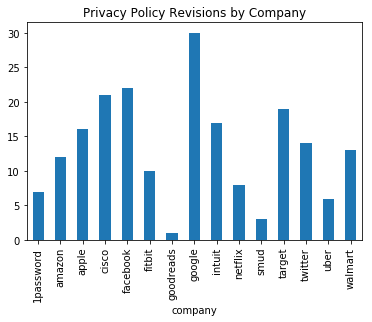

In [8]:
grouped = df.groupby('company').policy_path.count()
grouped.plot.bar(title='Privacy Policy Revisions by Company')

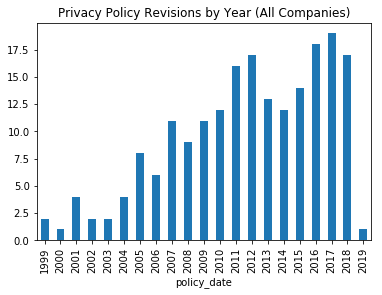

In [9]:
grouped = df.groupby([df.policy_date.dt.year]).policy_path.count()
grouped.plot.bar(title='Privacy Policy Revisions by Year (All Companies)')

## Google

In [10]:
google = df[df.company == 'google']
google.head()

,company,policy_date,policy_url,policy_path
95,google,1999-06-09,https://policies.google.com/privacy/archive/19...,google/google-1999-06-09.txt
96,google,1999-09-20,https://policies.google.com/privacy/archive/19...,google/google-1999-09-20.txt
97,google,2001-01-04,https://policies.google.com/privacy/archive/20...,google/google-2001-01-04.txt
98,google,2004-07-01,https://policies.google.com/privacy/archive/20...,google/google-2004-07-01.txt
99,google,2005-10-14,https://policies.google.com/privacy/archive/20...,google/google-2005-10-14.txt


In [13]:
def get_policy_texts(policy_paths):
    """
    Creates a pd.Series of full text from policies

    Args:
        policy_paths: pd.Series, paths to policy txt files
        
    Returns:
        pd.Series, strings
    """
    texts = list()
    for p in policy_paths:
        with open(os.path.join(POLICY_DIR, p), 'r', encoding='utf-8') as f:
            page = f.read()
            texts.append(page)
    return pd.Series(texts)

In [17]:
get_policy_texts(df.policy_path)

FileNotFoundError: [Errno 2] No such file or directory: '../privacy-policies-through-time/netflix/netflix-2007-01-09.txt'